In [ ]:
import os
import dask
import json
from os.path import join, dirname, expanduser, splitext, basename
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import leafmap.leafmap as leafmap
from dotenv import load_dotenv
import xarray as xr
import rioxarray as rxr
from PIL import Image
from shapely.geometry import mapping, Polygon
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
# import delayed from dask
import dask

load_dotenv()

In [ ]:
state_label="" ## Put state label path 
state=""  ## Put state name
save_region="" ## Put region name after quad preprocessing
mosaic_id="" ## Put mosic id 
image_meta_data=f"{state}/{mosaic_id}/metadata.geojson" 
imagery_dir = f"imagery/{mosaic_id}"
state_label_path=f"{state_label}.geojson"
stete_shape_path=f"{state}.geojson" ##State shape path name
save_dir=f"{save_region}/" ## save dir
os.makedirs(save_dir, exist_ok=True)


In [ ]:
gdf_labels = gpd.read_file(state_label_path).drop("style", errors="ignore", axis=1)
color_mapping = {"CFCBK": "red", "FCBK": "orange", "Zigzag": "green"}
gdf_labels["style"] = gdf_labels["class_name"].apply(lambda x: {"color": color_mapping[x]})
gdf_images = gpd.read_file(image_meta_data)
gdf_image_paths = [join(f"", f"{Id}.tif") for Id in gdf_images["id"]] ## Put mosic id 

# images processing

In [ ]:
m=leafmap.Map()
m.add_basemap("HYBRID")
m.add_geojson(image_meta_data,zoom_to_layer=True)
m

In [ ]:
x = np.unique(np.concatenate([xr.open_dataset(path).x.values for path in gdf_image_paths]))
x.sort()
xdiff_index = pd.Series(x).diff().value_counts().index
y = np.unique(np.concatenate([xr.open_dataset(path).y.values for path in gdf_image_paths]))
y.sort()
diff_index = pd.Series(y).diff().value_counts().index

In [ ]:
ds=xr.open_mfdataset(gdf_image_paths)
print(ds)
assert len(ds.x.values) % 4096 == 0
assert len(ds.y.values) % 4096 == 0

##### only change this cell as needed

In [ ]:
#defining the image size and overlap
image_size= # Put images size 
overlap=  # Put overlap
gap_between_centers=image_size-overlap
x_centers=[image_size//2]
x_centers.extend(list(range(x_centers[0]+gap_between_centers, len(ds.x), gap_between_centers)))
x_centers=x_centers[:-1]
y_centers=[image_size//2]
y_centers.extend(list(range(y_centers[0]+gap_between_centers, len(ds.y), gap_between_centers)))
y_centers=y_centers[:-1]

In [ ]:
x_values=ds.x.values
y_values=ds.y.values

def get_geometry(x_idx,y_idx):
    start_x=x_values[x_idx-image_size//2] #left boundary
    start_y=y_values[y_idx-image_size//2] #buttom boundary
    end_x=x_values[x_idx+image_size//2] #right boundary
    end_y=y_values[y_idx+image_size//2] #top boundary
    return Polygon([(start_x,start_y),(end_x,start_y),(end_x,end_y),(start_x,end_y)])

X,Y=np.meshgrid(x_centers,y_centers)
geometries=[get_geometry(x,y) for x,y in tqdm(zip(X.ravel(),Y.ravel()))]
x_indices=[x for x in X.ravel()]
y_indices=[y for y in Y.ravel()]

In [ ]:
potential_image_gdf=gpd.GeoDataFrame(geometry=geometries)
potential_image_gdf["x_idx"]=x_indices
potential_image_gdf["y_idx"]=y_indices
potential_image_gdf.reset_index(inplace=True,drop=True)
potential_image_gdf.crs=ds.rio.crs

In [ ]:
shape_gdf=gpd.read_file(stete_shape_path)
shape_gdf=shape_gdf.to_crs("EPSG:3857")
assert potential_image_gdf.crs == shape_gdf.crs
images_within_shape = gpd.sjoin(shape_gdf, potential_image_gdf, predicate="contains")
images_within_shape = potential_image_gdf.loc[images_within_shape.index_right]

In [ ]:
m = leafmap.Map()
m.add_basemap("HYBRID")
m.add_gdf(shape_gdf, layer_name="Shape", style={"color": "black"})
m.add_gdf(images_within_shape, layer_name="Images within shape",zoom_to_layer=True)
m

In [ ]:
images_within_shape['x'] = images_within_shape['x_idx'].apply(lambda x: int(x_values[x]))
images_within_shape['y'] = images_within_shape['y_idx'].apply(lambda x: int(y_values[x]))

In [ ]:
os.makedirs(f"{save_region}", exist_ok=True)
images_within_shape.reset_index(drop=True).to_file(f"{save_region}/metadata.geojson", driver="GeoJSON")

In [ ]:
samples = []
x_idx_list = []
y_idx_list = []
for x_idx, y_idx in tqdm(zip(images_within_shape["x_idx"], images_within_shape["y_idx"])):
    x = x_values[x_idx]
    y = y_values[y_idx]
    save_path = join(save_dir, "images", f"{int(x)}_{int(y)}.tif")
    if os.path.exists(save_path):
        try:
            image = Image.open(save_path)
            assert image.size == (image_size, image_size)
            continue
        except Exception as e:
            print(f"Error: {e}")
            print(f"Loading {save_path} failed. Overwriting the file.")
    sample = ds.isel(x=slice(x_idx - image_size//2, x_idx + image_size//2), y=slice(y_idx - image_size//2, y_idx + image_size//2), band=slice(0, 3))
    samples.append(sample)
    x_idx_list.append(x_idx)
    y_idx_list.append(y_idx)

In [53]:
def save_sample(sample, x_idx, y_idx):
    x = x_values[x_idx]
    y = y_values[y_idx]
    save_path = join(save_dir, "images", f"{int(x)}_{int(y)}.tif")
    
    sample = sample.band_data.load()
    # fill NaN values with 0
    sample = sample.fillna(0)
    # convert to uint8
    sample = sample.astype(np.uint8)
    sample.rio.to_raster(save_path)
    del sample

In [ ]:
delayed_tasks = [dask.delayed(save_sample)(sample, x_idx, y_idx) for sample, x_idx, y_idx in tqdm(zip(samples, x_idx_list, y_idx_list))]
print("Number of delayed tasks:", len(delayed_tasks))

In [ ]:
os.makedirs(join(save_dir, "images"), exist_ok=True)
for i in tqdm(range(0, len(delayed_tasks), 1000)):
    _ = dask.compute(*delayed_tasks[i:i+1000])

# Labels Processing

In [ ]:
## Load the state geojson
gdf_labels_webm=gdf_labels.to_crs(potential_image_gdf.crs)
gdf_labels_webm.reset_index(inplace=True, drop=True)
print(gdf_labels_webm.crs)
print("Number of labels:", len(gdf_labels_webm))

gdf_labels_webm.head(2)

In [57]:
images_with_label=gpd.sjoin(images_within_shape,gdf_labels_webm,predicate="contains")
images_with_label['geometry_right'] = images_with_label['index_right'].apply(lambda x: gdf_labels_webm.loc[x, 'geometry'])
print(f"Number of labels to write: {len(images_with_label)}")

print(f"Number of unique images: {len(images_with_label.drop_duplicates(subset='geometry'))}")
print(f"Number of unique labels: {len(images_with_label.drop_duplicates(subset='geometry_right'))}")

Number of labels to write: 281
Number of unique images: 55
Number of unique labels: 249


In [59]:
class_mapping = {"CFCBK": 0, "FCBK": 1, "Zigzag": 2}

def get_yolo_label(x):
    min_x, min_y, max_x, max_y = x['geometry'].bounds
    coords = np.array(x['geometry_right'].__geo_interface__['coordinates'][0])
    coords = coords[:-1]
    # normalize
    coords[:, 0] = (coords[:, 0] - min_x) / (max_x - min_x)
    coords[:, 1] = 1 - (coords[:, 1] - min_y) / (max_y - min_y)
    
    coords = coords.ravel()
    assert len(coords) == 8
    
    class_id = class_mapping[x['class_name']]
    label = np.zeros(9) * np.nan
    label[0] = class_id
    label[1:] = coords
    return label



In [60]:
images_with_label['yolo_label'] = images_with_label.apply(get_yolo_label, axis=1)
images_with_label.head(2)
ready_to_save_gdf = images_with_label.groupby("geometry").agg({"yolo_label": np.vstack, "x_idx": "first", "y_idx": "first"}).reset_index()
len(ready_to_save_gdf)

55

In [ ]:
ready_to_save_gdf['x'] = ready_to_save_gdf['x_idx'].apply(lambda x: str(int(x_values[x])))
ready_to_save_gdf['y'] = ready_to_save_gdf['y_idx'].apply(lambda x: str(int(y_values[x])))
len(ready_to_save_gdf)
display(ready_to_save_gdf.tail(2))

In [ ]:
def save_label(x):
    label = x['yolo_label']
    save_path = join(save_dir, "labels", f"{x['x']}_{x['y']}.txt")
    np.savetxt(save_path, label, fmt="%d %f %f %f %f %f %f %f %f")
    
print(f"{save_dir=}")
os.makedirs(join(save_dir, "labels"), exist_ok=True)
_ = ready_to_save_gdf.apply(save_label, axis=1)

(640, 640)


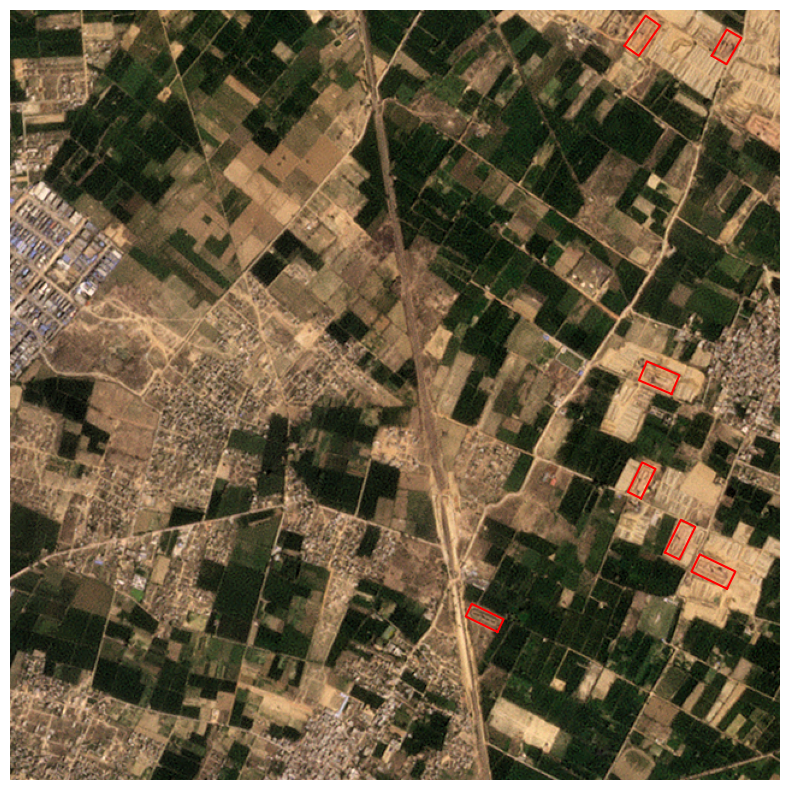

In [64]:
label_files = glob(join(save_dir, "labels", "*.txt"))
label_file = np.random.choice(label_files)
image_file = join(save_dir, "images", basename(splitext(label_file)[0] + ".tif"))

plt.figure(figsize=(10, 10))
image = Image.open(image_file)
print(image.size)
plt.imshow(image)
plt.axis("off")

labels = np.loadtxt(label_file, ndmin=2)
for label in labels:
    label[1:] = label[1:] * image_size
    plt.plot([label[1], label[3], label[5], label[7], label[1]], [label[2], label[4], label[6], label[8], label[2]], "r-")